In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import csv
import datetime
from collections import Counter

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', None) 
pd.options.plotting.backend = "plotly"

In [2]:
directory = "API-logs/"

### Code Carbon logs

In [3]:
carbondf = pd.DataFrame(columns = ['date', 'timestamp', 'RAM energy', 'GPU energy', 'CPU energy', 'Energy consumed'])

In [4]:
ins=[]
with open(directory+'carbon.log' , 'r') as f:
    lines = f.readlines() # readlines creates a list of the lines
    for line in lines:
        if 'Sep' in line:
            ins.append(lines.index(line))
len(lines)

143138

In [5]:
alldates, sep22, sep23, sep24, sep25, sep26= [], [], [], [], [], []
sep22 = lines[ins[0]:ins[1]]
print(len(sep22))
alldates.append(sep22)
sep23 = lines[ins[1]:ins[2]]
print(len(sep23))
alldates.append(sep23)
sep24 = lines[ins[2]:ins[3]]
alldates.append(sep24)
print(len(sep24))
sep25 = lines[ins[3]:ins[4]]
alldates.append(sep25)
print(len(sep25))
sep26 = lines[ins[4]:len(lines)]
alldates.append(sep26)
print(len(sep26))

13408
36577
36573
36577
20003


In [6]:
count=0
for day in alldates: 
    date= day[0].replace('\n','')
    print(date)
    print(len(day))
    for i in range(1, len(day), 4):
        for line in day[i:i + 4]:
            try:
                time = line.split('@')[1].split(']')[0].strip()
            except:
                continue
            if 'RAM :' in line: 
                ram_nrj = line.split('Energy consumed for RAM :')[1].split('RAM')[0].replace('kWh.','')
            elif 'GPUs'in line:
                gpu_nrj = line.split('Energy consumed for all GPUs :')[1].split('All GPUs')[0].replace('kWh.','')
            elif 'CPUs' in line:
                cpu_nrj= line.split('Energy consumed for all CPUs :')[1].split('All CPUs')[0].replace('kWh.','')
            elif ' electricity used since the begining.' in line:
                total_nrj = line.split(' electricity used since the begining.')[0].split(']')[1].replace(' of','').replace('kWh','')
        carbondf.loc[count] = [date, time, ram_nrj, gpu_nrj, cpu_nrj, total_nrj]
        count+=1

22/Sep/2022
13408
23/Sep/2022
36577
24/Sep/2022
36573
25/Sep/2022
36577
26/Sep/2022
20003


In [7]:
carbondf["Energy consumed"] = pd.to_numeric(carbondf["Energy consumed"])

In [8]:
carbondf.shape

(35784, 6)

In [9]:
carbondf.date.value_counts()

23/Sep/2022    9144
25/Sep/2022    9144
24/Sep/2022    9143
26/Sep/2022    5001
22/Sep/2022    3352
Name: date, dtype: int64

In [10]:
#carbondf = carbondf.sort_values('Energy consumed')
#carbondf = carbondf.reset_index(drop=True)

In [11]:
carbondf.head()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed
0,22/Sep/2022,15:12:02,0.001395,0.006703,0.000125,0.008222
1,22/Sep/2022,15:12:12,0.002708,0.013103,0.000243,0.016054
2,22/Sep/2022,15:12:22,0.004022,0.021320,0.000361,0.025703
3,22/Sep/2022,15:12:32,0.005333,0.024947,0.000478,0.030758
4,22/Sep/2022,15:12:42,0.006658,0.028631,0.000597,0.035886


In [12]:
carbondf['time'] = carbondf['date'] + ' ' + carbondf['timestamp'].astype(str)

In [13]:
carbondf['time'] = pd.to_datetime(carbondf['time'] , format= "%d/%b/%Y %H:%M:%S")

In [262]:
carbondf.tail()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed,time
35779,26/Sep/2022,13:07:07,44.674263,149.981416,3.991420,198.645777,2022-09-26 13:07:07
35780,26/Sep/2022,13:07:08,44.674263,149.985048,3.991539,198.650850,2022-09-26 13:07:08
35781,26/Sep/2022,13:07:08,44.674263,149.985048,3.991539,198.650850,2022-09-26 13:07:08
35782,26/Sep/2022,13:07:17,44.675578,149.991459,3.991539,198.650850,2022-09-26 13:07:17
35783,26/Sep/2022,13:07:18,44.675578,149.991459,3.991657,198.658694,2022-09-26 13:07:18


## Energy consumption by 15 min

In [394]:
carbonhourdf = carbondf.groupby(pd.Grouper(key = 'time', freq='10min')).last()
carbonhourdf.tail()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed
time,,,,,,
2022-09-26 12:20:00,26/Sep/2022,12:29:57,44.379839,148.984825,3.965095,197.319061
2022-09-26 12:30:00,26/Sep/2022,12:39:58,44.459049,149.254942,3.972296,197.686286
2022-09-26 12:40:00,26/Sep/2022,12:49:57,44.538203,149.543014,3.979260,198.052738
2022-09-26 12:50:00,26/Sep/2022,12:59:58,44.617507,149.795291,3.986463,198.399261
2022-09-26 13:00:00,26/Sep/2022,13:07:18,44.675578,149.991459,3.991657,198.658694


In [395]:
carbonhourdf['Energy by interval'] = carbonhourdf["Energy consumed"].diff()

In [396]:
carbonhourdf = carbonhourdf.iloc[7:-1 , :]
carbonhourdf.shape

(556, 7)

In [397]:
carbonhourdf.head()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed,Energy by interval
time,,,,,,,
2022-09-22 16:20:00,22/Sep/2022,16:29:52,0.616152,2.986218,0.055257,3.651571,0.460664
2022-09-22 16:30:00,22/Sep/2022,16:39:52,0.695054,3.367438,0.062223,4.123394,0.471823
2022-09-22 16:40:00,22/Sep/2022,16:49:53,0.773883,3.757831,0.069425,4.592904,0.469510
2022-09-22 16:50:00,22/Sep/2022,16:59:52,0.852737,4.133765,0.076390,5.061579,0.468675
2022-09-22 17:00:00,22/Sep/2022,17:09:53,0.931576,4.517707,0.083592,5.525039,0.463460


In [398]:
carbonhourdf.tail()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed,Energy by interval
time,,,,,,,
2022-09-26 12:10:00,26/Sep/2022,12:19:58,44.300638,148.691290,3.958129,196.950057,0.365278
2022-09-26 12:20:00,26/Sep/2022,12:29:57,44.379839,148.984825,3.965095,197.319061,0.369004
2022-09-26 12:30:00,26/Sep/2022,12:39:58,44.459049,149.254942,3.972296,197.686286,0.367225
2022-09-26 12:40:00,26/Sep/2022,12:49:57,44.538203,149.543014,3.979260,198.052738,0.366452
2022-09-26 12:50:00,26/Sep/2022,12:59:58,44.617507,149.795291,3.986463,198.399261,0.346523


### Server logs

In [94]:
with open(directory+'time-server.log','r') as f:
    lines = f.readlines() # readlines creates a list of the lines
len(lines)

54481

In [95]:
requestdf = pd.DataFrame(columns = ['date', 'requests'])

In [96]:
import re
count=0
for line in lines:
    if "POST /generate HTTP/1.1" in line:
        time = line.split('[')[1].split(']')[0]
        code = line.split("POST /generate HTTP/1.1")[1]
        code= re.sub("[^0-9]", "", code)
        code= code.replace('0400','400')
        requestdf.loc[count] = [time, code]
        count+=1

In [97]:
requestdf['date'] = pd.to_datetime(requestdf['date'] , format= "%d/%b/%Y %H:%M:%S")

In [98]:
requestdf['requests'] = pd.to_numeric(requestdf['requests'])

In [100]:
requestdf.requests.value_counts()

200    53332
400     1149
Name: requests, dtype: int64

200 = OK we answered

400 = used bad request

503 = refused because no more room in the queue

### Average number of requests per hour

In [401]:
requesthourdf = requestdf.groupby(pd.Grouper(key = 'date', freq='60min')).count()
requesthourdf['requests'].describe()

date
2022-09-26 12:30:00    137
2022-09-26 12:40:00    139
2022-09-26 12:50:00     75
2022-09-26 13:00:00    112
2022-09-26 13:10:00     27
Freq: 10T, Name: requests, dtype: int64

### Number of requests per 15 minutes

In [410]:
requesthourdf = requestdf.groupby(pd.Grouper(key = 'date', freq='10min')).count()
requesthourdf = requesthourdf.iloc[7:-2 , :]
requesthourdf.tail()

,requests
date,
2022-09-26 12:10:00,129
2022-09-26 12:20:00,133
2022-09-26 12:30:00,137
2022-09-26 12:40:00,139
2022-09-26 12:50:00,75


In [411]:
requesthourdf.head()
#2022-09-22 16:20:00

,requests
date,
2022-09-22 16:20:00,237
2022-09-22 16:30:00,243
2022-09-22 16:40:00,213
2022-09-22 16:50:00,227
2022-09-22 17:00:00,208


In [412]:
requesthourdf.shape

(556, 1)

### Merging the carbon and request DFs

In [413]:
alllogdf = pd.concat([carbonhourdf,requesthourdf], axis=1)
alllogdf['date']= alllogdf.index
alllogdf.shape

(556, 8)

Total time for logs:

In [419]:
alllogdf_diff = alllogdf.iloc[[0, -1]]
alllogdf_diff['date'].iloc[1] -  alllogdf_diff['date'].iloc[0]

Timedelta('3 days 20:30:00')

In [274]:
alllogdf.tail()

,date,timestamp,RAM energy,GPU energy,CPU energy,Energy consumed,Energy by interval,requests
2022-09-26 11:45:00,2022-09-26 11:45:00,11:59:57,44.141909,148.180237,3.943960,196.266107,0.503662,140
2022-09-26 12:00:00,2022-09-26 12:00:00,12:14:57,44.261019,148.551300,3.954586,196.762001,0.495894,115
2022-09-26 12:15:00,2022-09-26 12:15:00,12:29:57,44.379839,148.984825,3.965095,197.319061,0.557060,206
2022-09-26 12:30:00,2022-09-26 12:30:00,12:44:57,44.498630,149.395452,3.975719,197.868487,0.549426,209
2022-09-26 12:45:00,2022-09-26 12:45:00,12:59:58,44.617507,149.795291,3.986463,198.399261,0.530774,142


### Tons of carbon

In [449]:
((198.399261 * 394.0) /1e6)

0.078169308834

In [220]:
alllogdf["normalized energy"] = alllogdf['Energy by interval'] / alllogdf['Energy by interval'].max()
alllogdf["normalized requests"] = alllogdf["requests"] / alllogdf["requests"].max()

In [221]:
alllogdf['log energy'] = np.log10(alllogdf['Energy by interval'] )
alllogdf['log requests'] = np.log10(alllogdf['requests'] )

### Plotting raw values

In [222]:
alllogdf.plot(x="date", y=["requests"], kind="line")

In [416]:
fig= alllogdf.plot(kind="scatter", x="requests", y="Energy by interval")
fig.update_layout(
    xaxis_title= "Number of requests received in a 10-minute interval",
    yaxis_title="Energy consumption (kWh)",
)

### Trying to fit quadratic curve

In [417]:
x= alllogdf["requests"]
y= alllogdf["Energy by interval"]

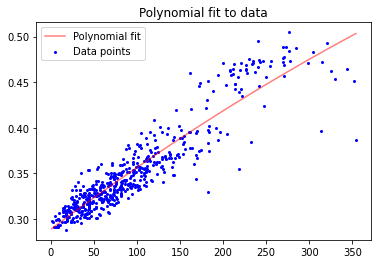

In [418]:
import numpy as np
from scipy.optimize import curve_fit

a, b, c = np.polyfit(x, y, 2)

fit_equation = lambda x: a * x ** 2 + b * x + c

def plot_fit(X, Y, f):
    X_fit = np.linspace(min(X), max(X), 1000)
    Y_fit = f(X_fit)

    fig, ax1 = plt.subplots()
    ax1.plot(X_fit, Y_fit, color='r', alpha=0.5, label='Polynomial fit')
    ax1.scatter(X, Y, s=4, color='b', label='Data points')
    ax1.set_title('Polynomial fit to data')
    ax1.legend()
    plt.show()
    
plot_fit(x, y, fit_equation)


#### Calculating intercept:

In [227]:
fit_equation(0)

0.4293112651910953

### Plotting normalized values

In [226]:
alllogdf.plot(x="date", y=["normalized energy", "normalized requests"], kind="line")